## Visualize V-plot


### Interesting papers on ATAC-seq footprinting
- https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1642-2
- https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1654-y

In [1]:
from basepair.imports import *

from basepair.exp.paper.config import *

fdir = Path(f'{ddir}/figures/method-comparison/vplot')
fdir.mkdir(exist_ok=True)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
paper_config()

In [3]:
ATAC_PROC_DIR = Path('/oak/stanford/groups/akundaje/projects/bpnet/ATACseq_processed')
CROO_DIR = ATAC_PROC_DIR / 'croo'
OUTPUT_DIR = Path('/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/data/atac')
METHODS = ['BPNet', 'MEME/FIMO']
closest_motifs = read_pkl("/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/chexmix-peakxus/closest_motifs.pkl")
motifs = list(closest_motifs)

In [4]:
df_id = pd.read_csv(ATAC_PROC_DIR / 'id_to_sample.txt', sep='\t',
                    usecols=['id', 'status', 'name', 'str_label'])

sample_to_id = {row.str_label: row.id for i,row in df_id.iterrows()}


In [5]:
samples = list(sample_to_id)

In [6]:
def read_vplot_txt(sample, method, motif, top_n=2500, stranded=True, central_len=1000):
    paths = [f'{OUTPUT_DIR}/{sample}/v-plot/{method}/{motif}/counts.rep-{rep}.top-{top_n}.stranded={stranded}.central-{central_len}bp.txt'
             for rep in [1,2]]
    df = sum([pd.read_csv(path, sep='\t', index_col='#')
              for path in paths])
    df.columns = df.columns.astype(int)
    df.index = df.index + 1
    description = f'{motif} {sample} ({method})'
    return df, description

In [9]:
get_figsize(1)

(6.85038, 4.23353484)

In [72]:
for motif in motifs:
    for i, sample in enumerate(samples):
        for j,method in enumerate(METHODS):
            try:
                df, descr = read_vplot_txt(sample, method, motif)
            except:
                print(motif, sample, method)

In [17]:
for motif in tqdm(motifs):
    fig, axes = plt.subplots(len(samples), len(METHODS),
                             figsize=(9, 15),
                             sharex=True,
                             sharey=True,
                             constrained_layout=False,
                             gridspec_kw = {'wspace':0.05, 'hspace':0.05})
    for i, sample in enumerate(samples):
        for j,method in enumerate(METHODS):
            
            df, descr = read_vplot_txt(sample, method, motif)
            ax = axes[i,j]
            sns.heatmap(df, cmap='Reds', 
                        vmax=70,
                        xticklabels=100,
                        yticklabels=100,
                        # cbar_kws={"shrink": .5},
                        ax=ax,
                        cbar=False,
                        square=True)
            if j > 0:
                ax.get_yaxis().set_visible(False)
            if i < len(samples)-1:
                ax.get_xaxis().set_visible(False)
            ax.set_ylabel(sample.replace('ATAC_', '') if j ==0 else None, rotation=0, ha='right')
            ax.set_xlabel('Fragment length' if j == 0 and i == len(samples)-1 else None)
            ax.set_title(f'{motif} ({method})' if i == 0 else None);
    # fig.savefig(fdir / f'{motif}.pdf')  # PDF is too big (90 MB)
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(1)
    fig.savefig(fdir / f'{motif}.png', facecolor=fig.get_facecolor(), dpi=300, edgecolor='white')
    plt.close(fig)

100%|██████████| 11/11 [05:27<00:00, 29.69s/it]


### Footprints

1. Setup dataspec (different tasks = different experiments)
2. Extract

In [18]:
from basepair.cli.schemas import DataSpec, TaskSpec 
from pybedtools import BedTool
from basepair.preproc import resize_interval

In [15]:
def get_intervals_path(method, motif, top_N=2500, central_len=1000):
    dfi_list_dir = '/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/chexmix-peakxus'
    return f'{dfi_list_dir}/dfi_list.incl-conservation,is_erv-bed/{method}/{motif}/instances.top-{top_N}.central-{central_len}bp.bed'

In [32]:
def get_intervals(method, motif, width=200, top_N=2500):
    return [resize_interval(x, width) for x in BedTool(get_intervals_path(method, motif))]

In [21]:
fasta_file = '/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/data/mm10_no_alt_analysis_set_ENCODE.fasta'

In [25]:
main_motifs = ['Oct4-Sox2', 'Sox2', 'Nanog', 'Klf4']

In [22]:
ds = DataSpec(task_specs={sample: TaskSpec(pos_counts=f'{OUTPUT_DIR}/{sample}/coverage.sub150bp-fragments.pos.bw',
                                           neg_counts=f'{OUTPUT_DIR}/{sample}/coverage.sub150bp-fragments.neg.bw',
                                           task=sample)
                          for sample in samples},
              fasta_file=fasta_file)

In [23]:
ds.touch_all_files()

In [24]:
from basepair.plot.profiles import multiple_plot_stranded_profile

## Footprint - 1 kb regions

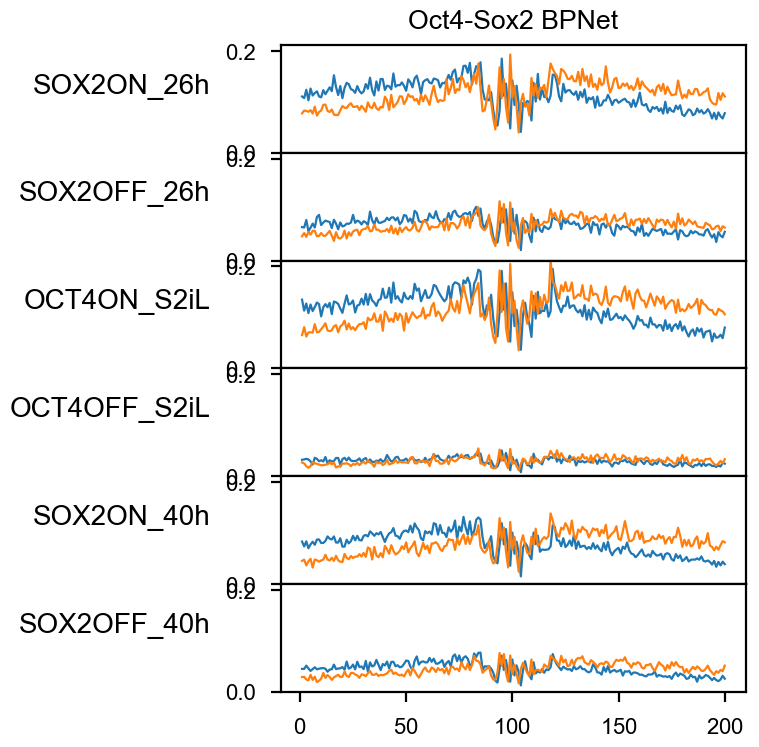

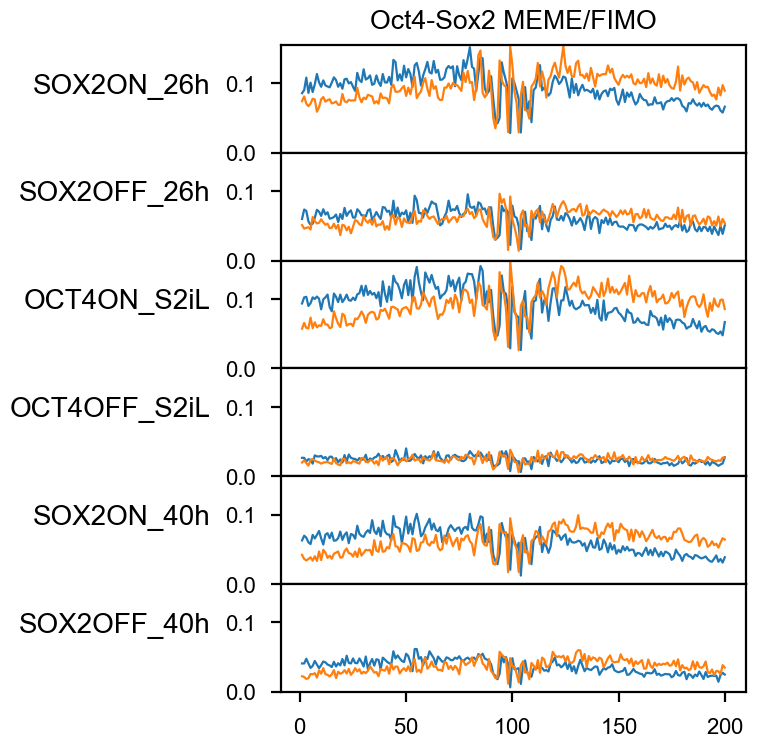

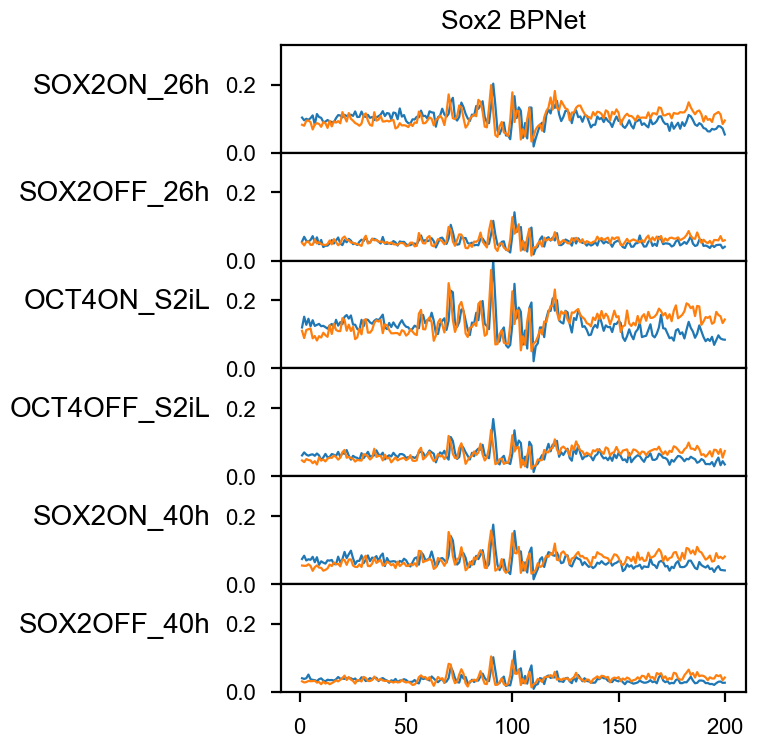

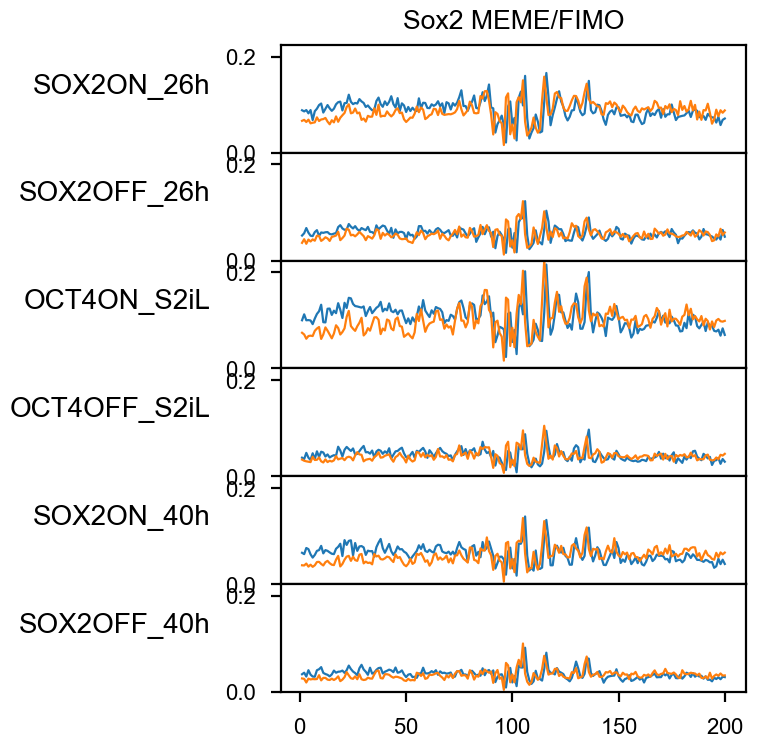

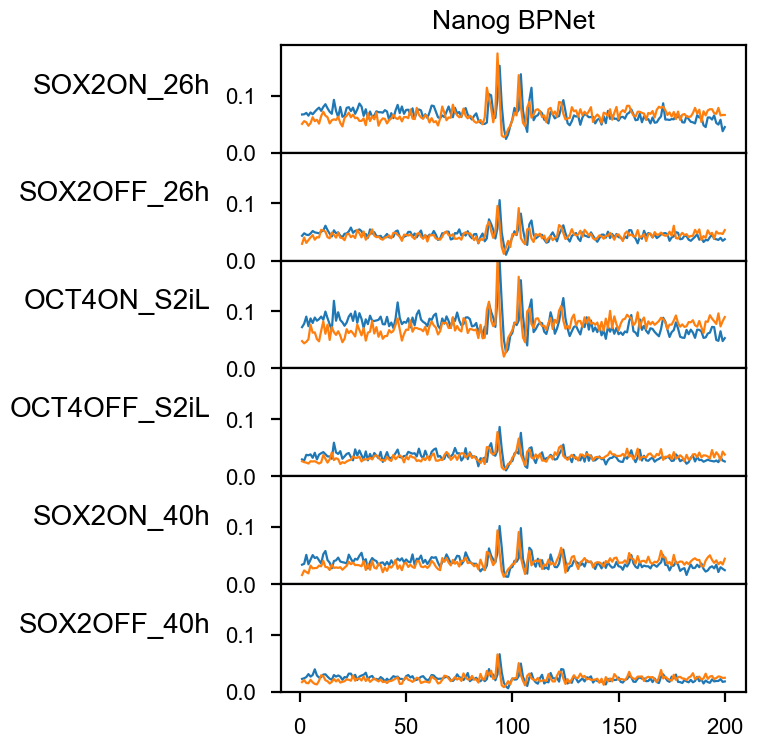

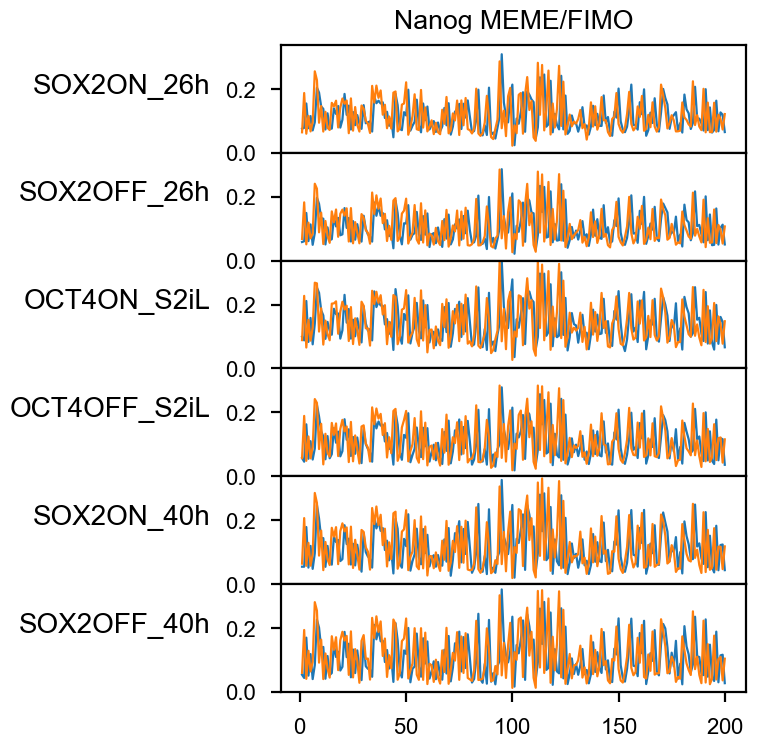

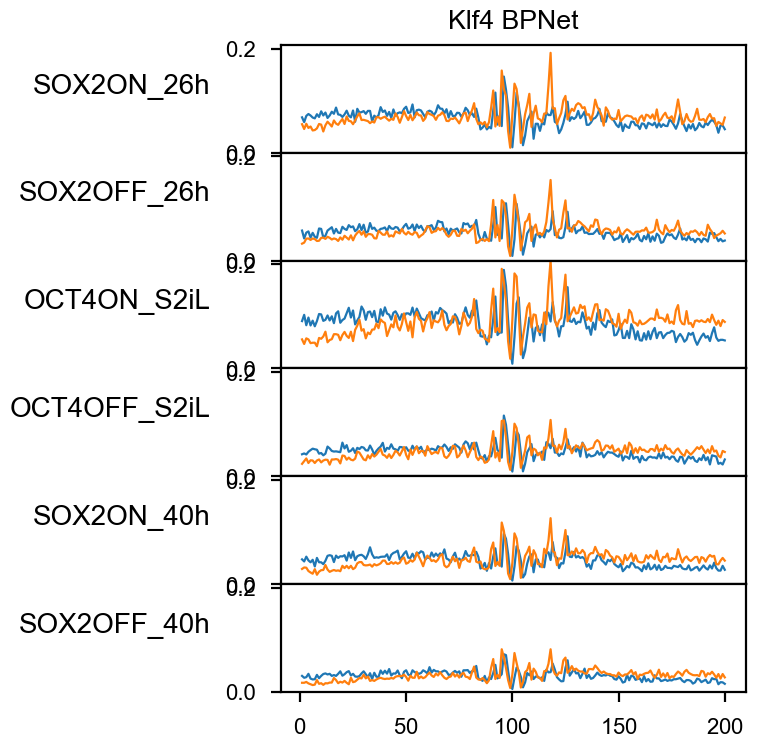

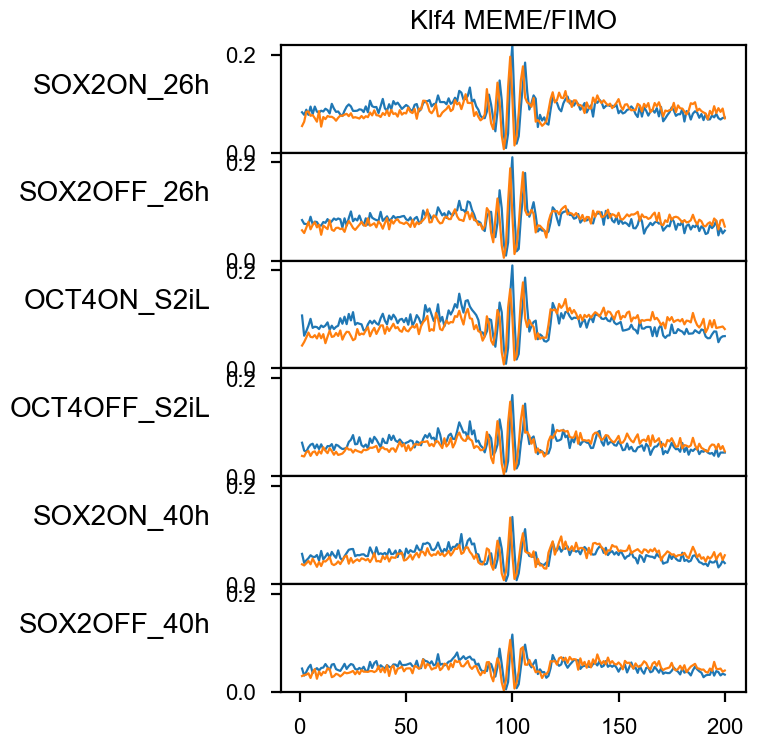

In [33]:
for motif in main_motifs:
    for method in METHODS:
        intervals = get_intervals(method, motif)
        counts = ds.load_counts(intervals)
        plot_tracks({k.replace('ATAC_', ''): v.mean(axis=0) for k,v in counts.items()},
                    fig_width=3,
                    fig_height_per_track=.7,
                    same_ylim=True,
                    rotate_y=0,
                    title=f'{motif} {method}');

## Footprint - central 200 bp regions

In [ ]:
for motif in main_motifs:
    for method in METHODS:
        intervals = get_intervals(method, motif, central_len=200)
        counts = ds.load_counts(intervals)
        plot_tracks({k.replace('ATAC_', ''): v.mean(axis=0) for k,v in counts.items()},
                    fig_width=3,
                    fig_height_per_track=.7,
                    same_ylim=True,
                    rotate_y=0,
                    title=f'{motif} {method}');

### Positive strand only 

In [ ]:
for motif in main_motifs:
    for method in METHODS:
        intervals = get_intervals(method, motif)
        intervals = [interval for interval in intervals if interval.strand == '+']
        counts = ds.load_counts(intervals)
        plot_tracks({k.replace('ATAC_', ''): v.mean(axis=0) for k,v in counts.items()},
                    fig_width=3,
                    fig_height_per_track=.7,
                    same_ylim=True,
                    rotate_y=0,
                    title=f'{motif} {method}');